### Specific Test III. Image Super-resolution


#### **Name**:potla naga sai bharath 
#### **Gmail**:[saibharathpotla29@gmail.com](mailto:saibharathpotla29@gmail.com)

**Task:** Train a deep learning-based super resolution algorithm of your choice to upscale low-resolution strong lensing images using the provided high-resolution samples as ground truths. Please implement your approach in PyTorch or Keras and discuss your strategy 

**Dataset Description:** The dataset comprises simulated strong lensing images with no substructure at multiple resolutions: high-resolution (HR) and low-resolution (LR)

**Evaluation Metrics:** MSE (Mean Squared Error), SSIM (Structural Similarity Index), PSNR (Peak Signal-to-Noise Ratio)

*Trained model weigths for this task can be found in the respective folder in [HERE](https://drive.google.com/drive/folders/1DGug4hP0UZBG2zAVWiO5lAgrlnf95l_Q?usp=drive_link)*


**Strategy**:
### SuperResCNN (Super-Resolution Convolutional Neural Network)
- Before attempting complex models on this task, we must try to establish a baseline model and analyze 


- The most optimal way to start is by implementing the SuperResCNN model that implements an upsampling layer followed by a three-layered neural network to learn the mapping between low-resolution and high-resolution images, such that the first layer can capture the low-level features, the second layer can capture high level features and the final layer can reconstruct the high resolution image

### EDSR (Enhanced Deep Residual Networks)
- Since the above SuperResCNN model has performed well, there could be a chance of improvement by training an EDSR model first (which has residual blocks that can help capture more complex image features) and then only if it works well, we can perform additional steps like cascading to take the output of the SuperResCNN and feed it to the EDSR.

### ESRGAN (Enhanced Super-Resolution Generative Adversarial Networks)
- Generative Adversarial Networks can result in extremely good results if problems such as mode collapse can be handled using appropriate loss functions.



- We can use Residual Dense Blocks (RRDB) to extract high-level features from the input image. A perceptual loss function can be used that measures the similarity between the high-resolution image generated by the generator and the ground truth high-resolution image. It is based on the VGG19 network and computes the mean squared error between the feature maps of the generated and ground truth images at a selected layer. This loss function encourages the generator to produce images that are visually similar to the ground truth images.

- we can use sub-pixel convolution for image upscaling, which enables the network to generate high-resolution images with finer details. This technique involves reshaping the features extracted from the previous layer into a tensor with a higher spatial resolution and then applying convolutional layers to produce the final high-resolution image.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

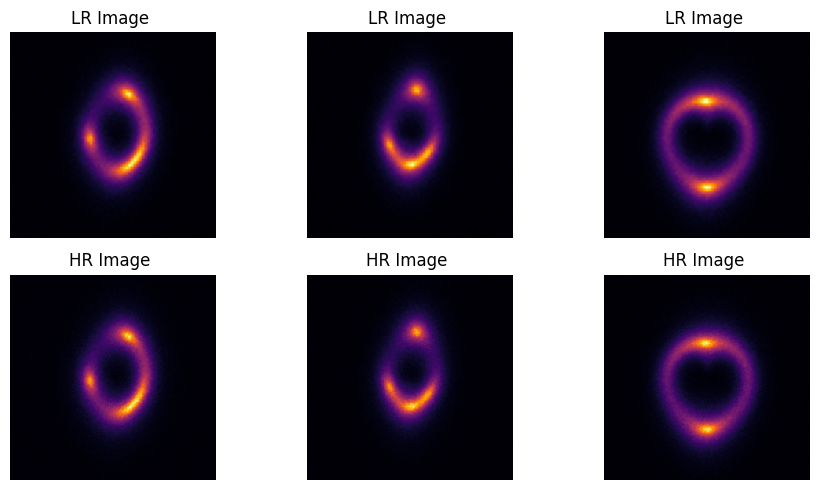

In [5]:
# Path to the main folder containing subfolders
main_folder = '/kaggle/working/Dataset'

# Subfolders for LR and HR images
lr_folder = os.path.join(main_folder, 'LR')
hr_folder = os.path.join(main_folder, 'HR')

# Load and plot first five LR images
plt.figure(figsize=(15, 5))
for i in range(1, 4):
    lr_image_path = os.path.join(lr_folder, f'sample{i}.npy')
    lr_image = np.load(lr_image_path)
    plt.subplot(2, 5, i)
    plt.imshow(lr_image.T,'inferno')
    plt.title(f'LR Image ')
    plt.axis('off')

# Load and plot first five HR images
for i in range(1, 4):
    hr_image_path = os.path.join(hr_folder, f'sample{i}.npy')
    hr_image = np.load(hr_image_path)
    plt.subplot(2, 5, i + 5)
    plt.imshow(hr_image.T,'inferno')
    plt.title(f'HR Image ')
    plt.axis('off')

plt.tight_layout()
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


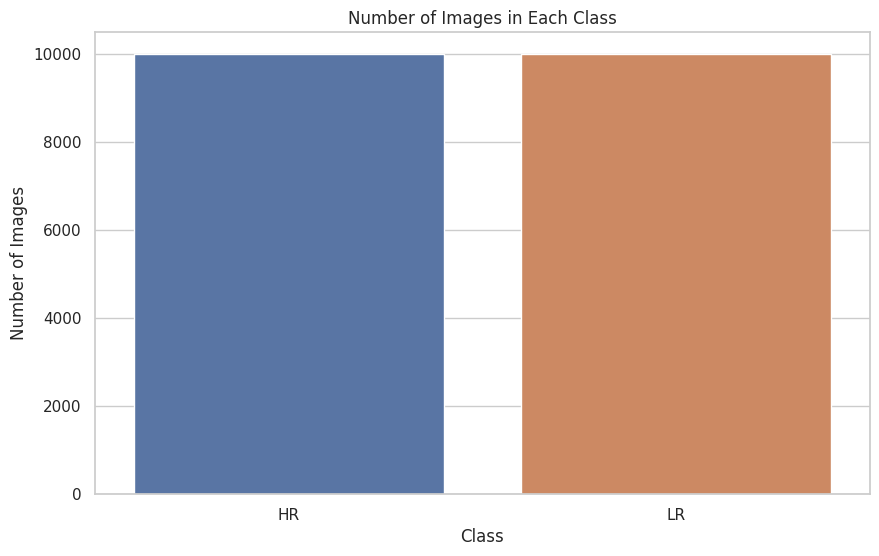

In [6]:
def count_images_per_class(data_dir):
    classes = os.listdir(data_dir)
    class_counts = []

    for cls in classes:
        cls_path = os.path.join(data_dir, cls)
        if os.path.isdir(cls_path):
            images = [f for f in os.listdir(cls_path) if f.endswith('.npy')]
            num_images = len(images)
            class_counts.append((cls, num_images))

    return class_counts

# Get the total number of images in each class
class_counts = count_images_per_class(main_folder)

# Plot the countplot
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.barplot(x=[cls[0] for cls in class_counts], y=[cls[1] for cls in class_counts])
plt.title('Number of Images in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

In [2]:
import glob 
from sklearn.model_selection import train_test_split
hr_images = np.array([np.load(file_path) for file_path in glob.glob('Dataset/HR/*.npy')])
lr_images = np.array([np.load(file_path) for file_path in glob.glob('Dataset/LR/*.npy')])

# Split into training and validation sets
train_hr, val_hr, train_lr, val_lr = train_test_split(hr_images, lr_images, test_size=0.1, random_state=42) # (None, 1, x, x)

# Preprocess the data

print(train_hr.shape, val_hr.shape, train_lr.shape, val_lr.shape)

(9000, 1, 150, 150) (1000, 1, 150, 150) (9000, 1, 75, 75) (1000, 1, 75, 75)


In [3]:
# Reshape the data to the format (batch, height, width, channel)
train_hr, val_hr =  np.reshape(train_hr, (9000,150, 150,1)),np.reshape(val_hr, (1000,150, 150,1))
train_lr, val_lr = np.reshape(train_lr, (9000,75, 75,1)),np.reshape(val_lr, (1000,75, 75,1))


In [4]:
def view_predictions(model, index, title):
    """
    About: 
      Display the low-resolution image, ground truth high-resolution image, and the predicted high-resolution image using a given model for a specified image index.
    
    """
    predicted_hr = model.predict(np.expand_dims(val_lr[index], axis=0))
    
    fig, ax = plt.subplots(1,3, figsize=(12, 8), dpi=140)
    ax[0].imshow(val_lr[index].squeeze(), cmap='inferno')
    ax[0].set_aspect('equal')
    ax[0].set_title('Low Resolution Image', fontsize=12)

    ax[1].imshow(val_hr[index].squeeze(),cmap='inferno')
    ax[1].set_aspect('equal')
    ax[1].set_title('Ground Truth High Resolution Image', fontsize=12)

    ax[2].imshow(predicted_hr.squeeze(),cmap='inferno')
    ax[2].set_aspect('equal')
    ax[2].set_title('Predicted Image', fontsize=12)

    plt.show()

In [9]:
def evaluate_models(model, val_lr, val_hr):
    """
    About: 
        Evaluates a given image super-resolution model on a validation set of low-resolution and high-resolution images, using mean squared error (MSE), structural similarity index (SSIM), and peak signal-to-noise ratio (PSNR) as evaluation metrics.
        
    """
    mse_values = []
    ssim_values = []
    psnr_values = []

    for i in range(len(val_lr)):
        # Predict the high-resolution image using the model
        pred_hr = model.predict(np.expand_dims(val_lr[i], axis=0), verbose = 0)[0]

        # Calculate the mean squared error
        mse = mean_squared_error(val_hr[i], pred_hr)
        mse_values.append(mse)

        # Calculate the structural similarity index
        ssim_val = ssim(val_hr[i], pred_hr, channel_axis=-1,gaussian_weights=True,sigma=1.5,use_sample_covariance=False, data_range=255)
        ssim_values.append(ssim_val)

        # Calculate the peak signal-to-noise ratio
        psnr_val = psnr(val_hr[i], pred_hr, data_range=pred_hr.max() - pred_hr.min())
        psnr_values.append(psnr_val)

    # Calculate the mean of the metrics
    mean_mse = np.mean(mse_values)
    mean_ssim = np.mean(ssim_values)
    mean_psnr = np.mean(psnr_values)
    return mean_mse, mean_ssim, mean_psnr

### SuperResCNN (Super-Resolution Convolutional Neural Network)

In [11]:
import keras
import keras.backend as K
from keras.optimizers import Adam
from keras.applications import VGG19
from keras.losses import MeanSquaredError
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Conv2D, UpSampling2D, Conv2DTranspose, Input, ReLU, Add, Lambda, Activation, LeakyReLU, BatchNormalization, Dense, Flatten, GlobalAveragePooling2D, Concatenate, Layer

from skimage.metrics import mean_squared_error, structural_similarity as ssim, peak_signal_noise_ratio as psnr
def create_srcnn_model():
    """
    SRCNN (Super-Resolution Convolutional Neural Network): This is a simple three-layer CNN architecture that can be trained end-to-end for image super-resolution. 
    
    """
    model = Sequential([
        UpSampling2D(size=(2, 2), input_shape=(75, 75, 1)),
        Conv2D(1024, (3, 3), activation='relu', padding='same'),
        Conv2D(512, (1, 1), activation='relu', padding='same'),
        Conv2D(1, (3, 3), activation='linear', padding='same')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),loss='mean_squared_error', metrics=['mae'])
    return model

srcnn = create_srcnn_model()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=0.00000001, mode='min')
history = srcnn.fit(train_lr, train_hr, validation_data=(val_lr, val_hr), epochs=10, batch_size=16, callbacks=[reduce_lr])

2024-03-29 15:26:01.954040: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-29 15:26:01.954158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-29 15:26:02.223122: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 1/10


I0000 00:00:1711725992.179083      91 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


563/563 [==============================] - 266s 438ms/step - loss: 1.2679e-04 - mae: 0.0058 - val_loss: 6.1574e-05 - val_mae: 0.0050 - lr: 0.0010
Epoch 2/10
563/563 [==============================] - 242s 430ms/step - loss: 6.1151e-05 - mae: 0.0050 - val_loss: 6.0046e-05 - val_mae: 0.0049 - lr: 0.0010
Epoch 3/10
563/563 [==============================] - 242s 429ms/step - loss: 6.0724e-05 - mae: 0.0049 - val_loss: 6.4093e-05 - val_mae: 0.0050 - lr: 0.0010
Epoch 4/10
563/563 [==============================] - ETA: 0s - loss: 6.2196e-05 - mae: 0.0050
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
563/563 [==============================] - 241s 429ms/step - loss: 6.2196e-05 - mae: 0.0050 - val_loss: 5.9764e-05 - val_mae: 0.0049 - lr: 0.0010
Epoch 5/10
563/563 [==============================] - 241s 429ms/step - loss: 6.0094e-05 - mae: 0.0049 - val_loss: 5.9745e-05 - val_mae: 0.0049 - lr: 1.0000e-04
Epoch 6/10
563/563 [==============================] - 242s 43

In [12]:
srcnn.save('srcnn.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [5]:
 srcnn = load_model('srcnn.h5',compile=False)

In [14]:
mean_mse, mean_ssim, mean_psnr = evaluate_models(srcnn, val_lr, val_hr)
print("Mean Squared Error: ", mean_mse)
print("Structural Similarity Index: ", mean_ssim,)
print("Peak Signal-to-Noise Ratio: ",mean_psnr)

Mean Squared Error:  5.971182729772909e-05
Structural Similarity Index:  0.9999987684283035
Peak Signal-to-Noise Ratio:  41.97958706945114


1/1 [==============================] - 18s 18s/step


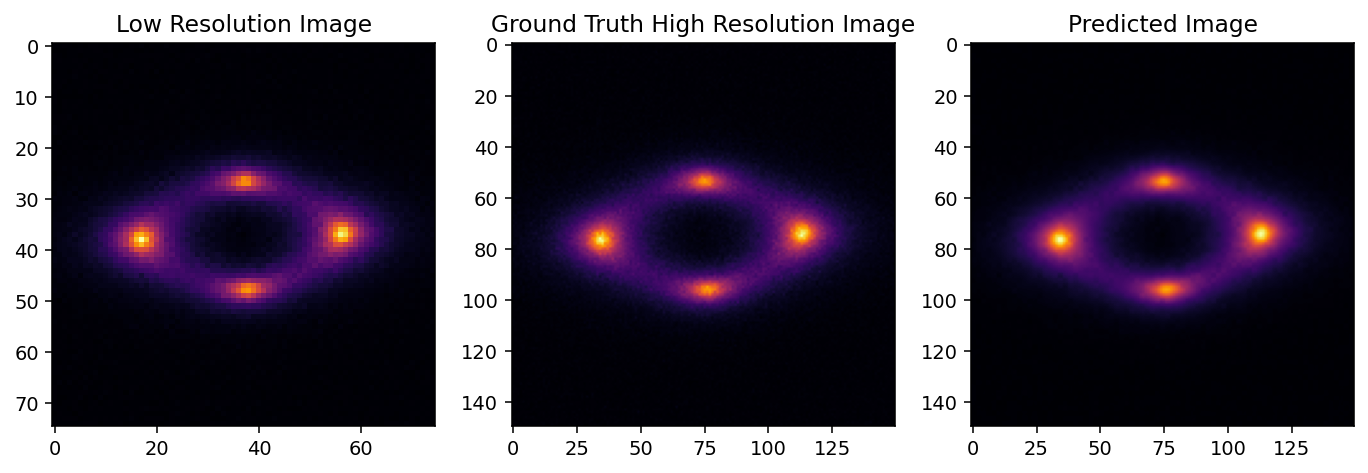

1/1 [==============================] - 0s 27ms/step


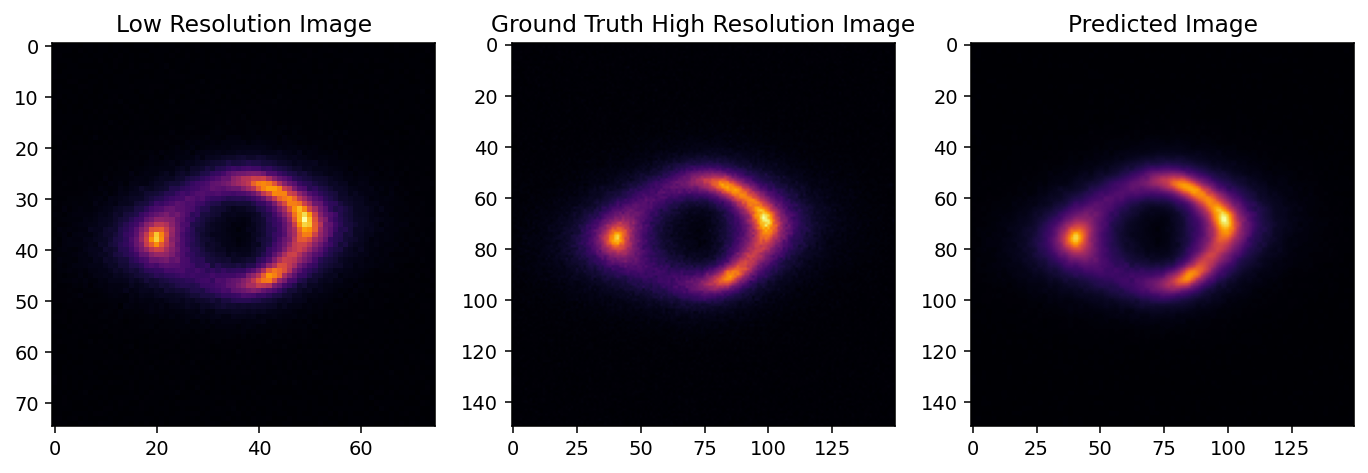

1/1 [==============================] - 0s 17ms/step


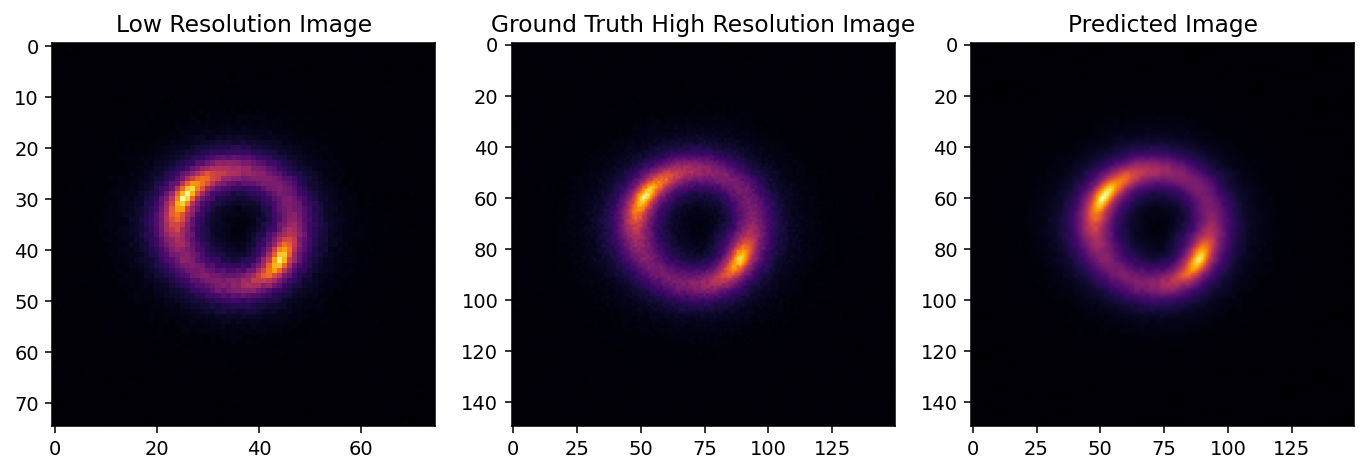

1/1 [==============================] - 0s 19ms/step


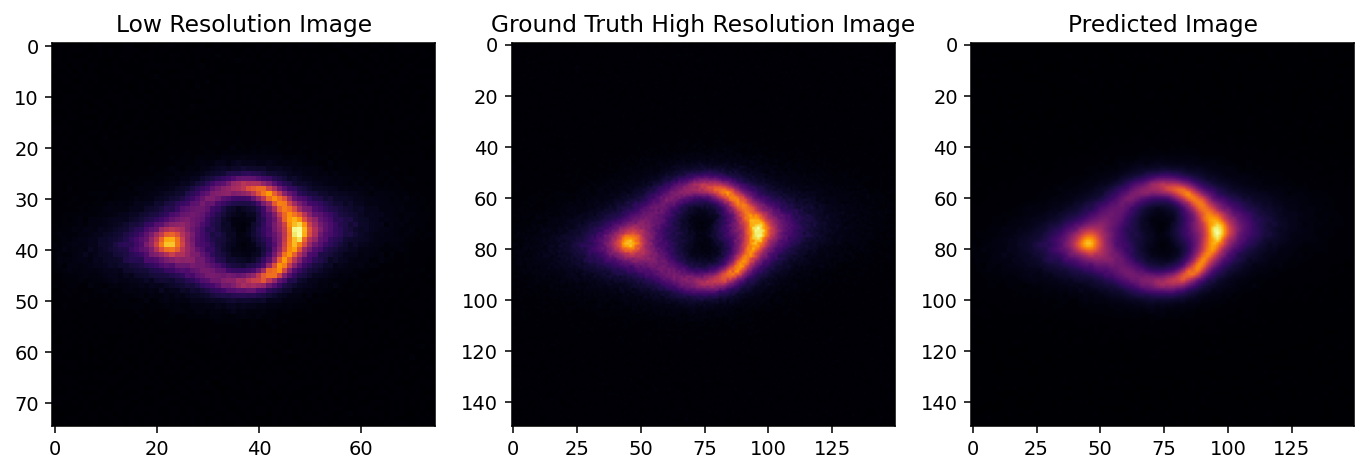

1/1 [==============================] - 0s 13ms/step


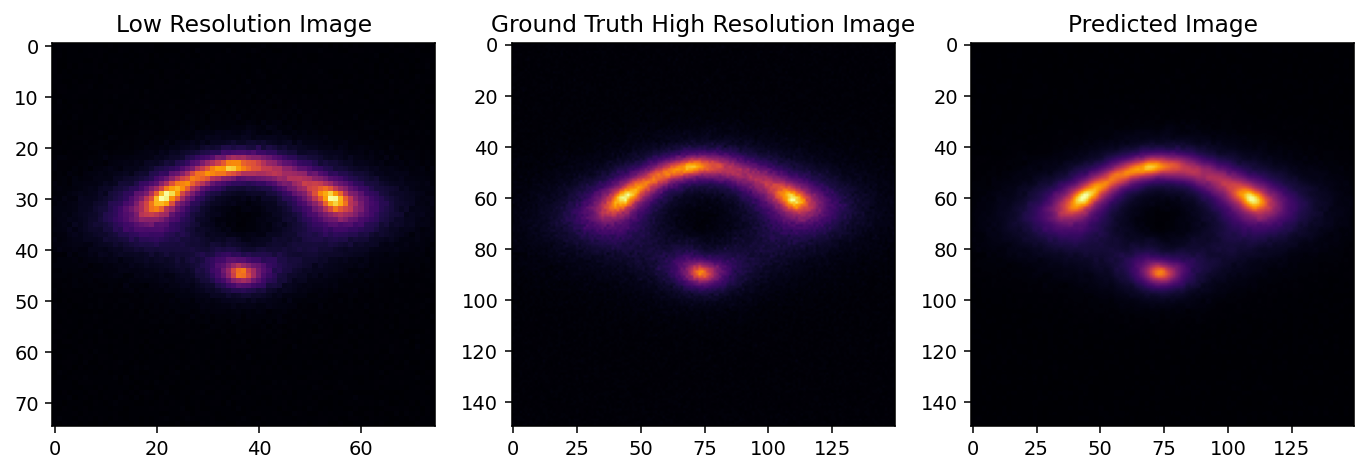

In [6]:
for i in range(5):
    view_predictions(srcnn, i, f'Image {i+1}')

### EDSR (Enhanced Deep Residual Networks)

In [17]:
def residual_block(x, nf=256):
    tmp = Conv2D(nf, (3, 3), padding='same', activation='relu')(x)
    tmp = BatchNormalization()(tmp) 
    tmp = Conv2D(nf, (3, 3), padding='same')(tmp)
    tmp = BatchNormalization()(tmp) 
    return Add()([x, tmp])

def upsample(x, scale=2, nf=256):
    def upsample_1(x, factor, **kwargs):
        return Lambda(lambda x: keras.backend.resize_images(x, factor, factor, "channels_last", "nearest"))(x)
    
    x = upsample_1(x, scale, interpolation='nearest')
    x = Conv2D(nf, (3, 3), padding='same', activation='relu')(x)
    return x

In [18]:
def EDSR_model(input_shape, scale=2, num_res_blocks=4, nf=256):
    inputs = Input(shape=input_shape)
    x = Conv2D(nf, (3, 3), padding='same', activation='relu')(inputs)
    conv1 = x
    for _ in range(num_res_blocks):
        x = residual_block(x, nf)
    x = Conv2D(nf, (3, 3), padding='same')(x)
    x = Add()([x, conv1])
    x = upsample(x, scale, nf)
    outputs = Conv2D(1, (1, 1), padding='same')(x)
    return Model(inputs=inputs, outputs=outputs)

edsr = EDSR_model((75, 75, 1), scale=2, num_res_blocks=4, nf=256)
edsr.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mse', 'mae'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_lr=0.00000001, mode='min')

In [19]:
edsr.fit(train_lr, train_hr, epochs=10, batch_size=16, validation_data=(val_lr, val_hr), callbacks = [reduce_lr])


Epoch 1/10
563/563 [==============================] - 316s 523ms/step - loss: 11.5162 - mse: 11.5162 - mae: 0.5517 - val_loss: 0.0269 - val_mse: 0.0269 - val_mae: 0.1452 - lr: 0.0010
Epoch 2/10
563/563 [==============================] - 285s 506ms/step - loss: 0.0237 - mse: 0.0237 - mae: 0.1150 - val_loss: 0.0584 - val_mse: 0.0584 - val_mae: 0.2028 - lr: 0.0010
Epoch 3/10
563/563 [==============================] - ETA: 0s - loss: 0.0321 - mse: 0.0321 - mae: 0.1239
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
563/563 [==============================] - 285s 506ms/step - loss: 0.0321 - mse: 0.0321 - mae: 0.1239 - val_loss: 0.0676 - val_mse: 0.0676 - val_mae: 0.2432 - lr: 0.0010
Epoch 4/10
563/563 [==============================] - 286s 507ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0320 - val_loss: 0.0018 - val_mse: 0.0018 - val_mae: 0.0339 - lr: 1.0000e-04
Epoch 5/10
563/563 [==============================] - 285s 507ms/step - loss: 0.0016 - mse: 0.0016 

In [20]:
edsr.save('edsr.h5')


In [12]:
 edsr = load_model('edsr.h5',compile=False)

In [22]:
mean_mse, mean_ssim, mean_psnr = evaluate_models(edsr, val_lr, val_hr)
print("Mean Squared Error: ", mean_mse)
print("Structural Similarity Index: ", mean_ssim,)
print("Peak Signal-to-Noise Ratio: ",mean_psnr)

Mean Squared Error:  0.0009449294662199594
Structural Similarity Index:  0.9999375134032251
Peak Signal-to-Noise Ratio:  31.99553003490593


1/1 [==============================] - 1s 1s/step


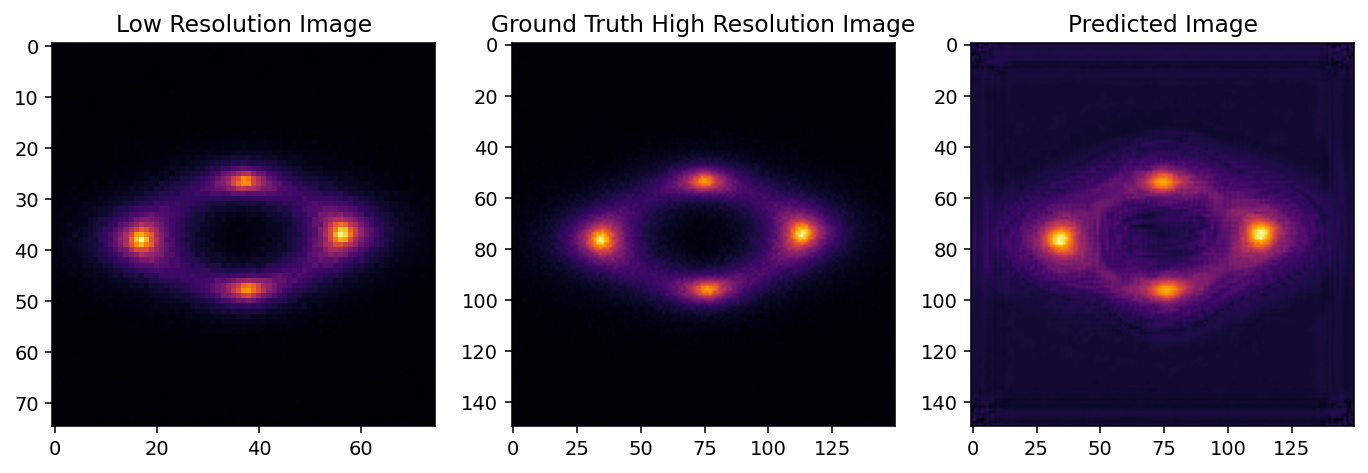

1/1 [==============================] - 0s 21ms/step


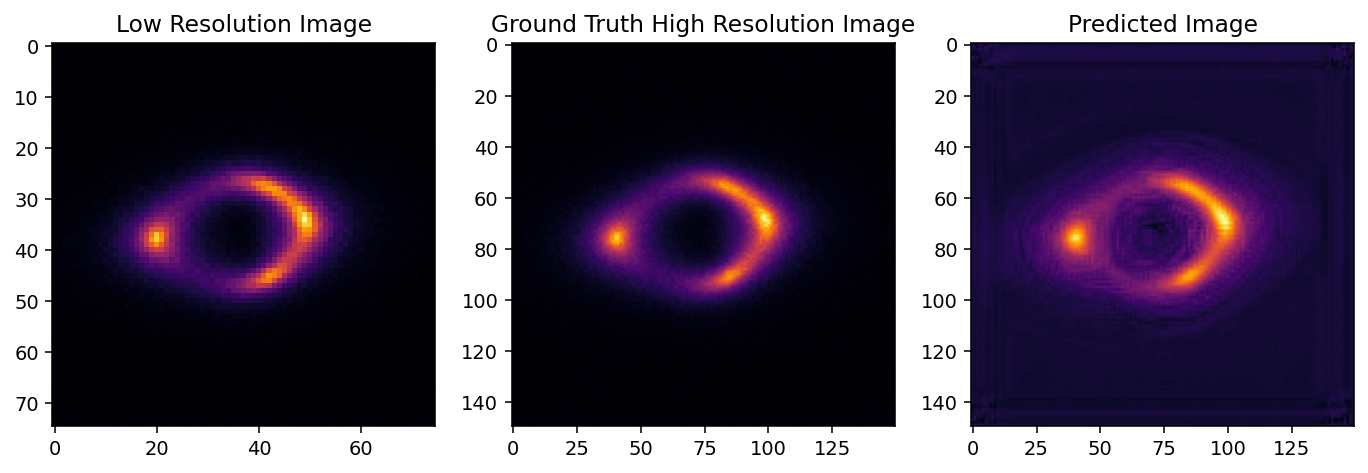

1/1 [==============================] - 0s 22ms/step


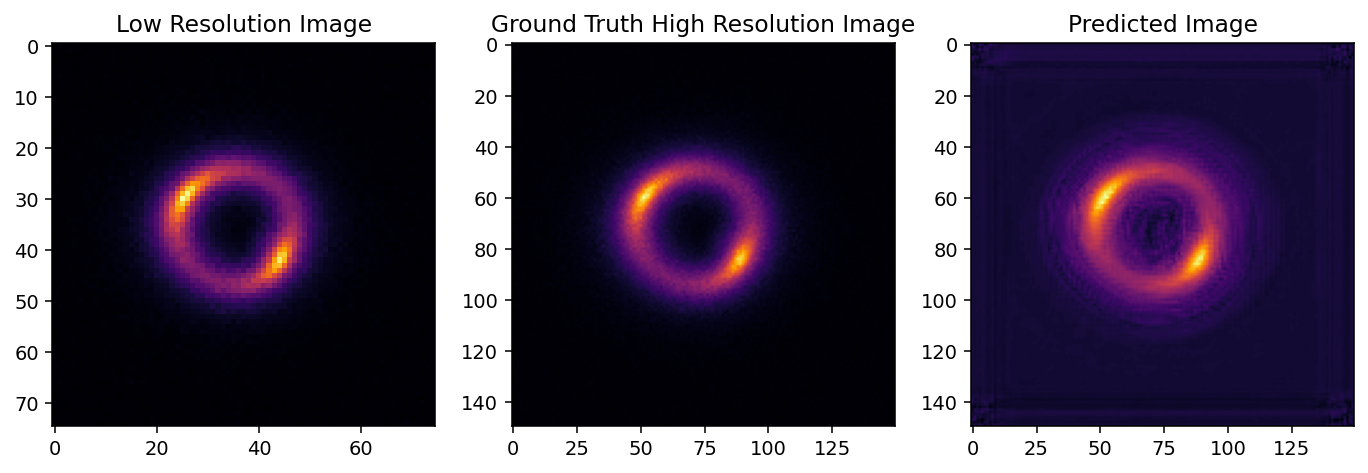

1/1 [==============================] - 0s 25ms/step


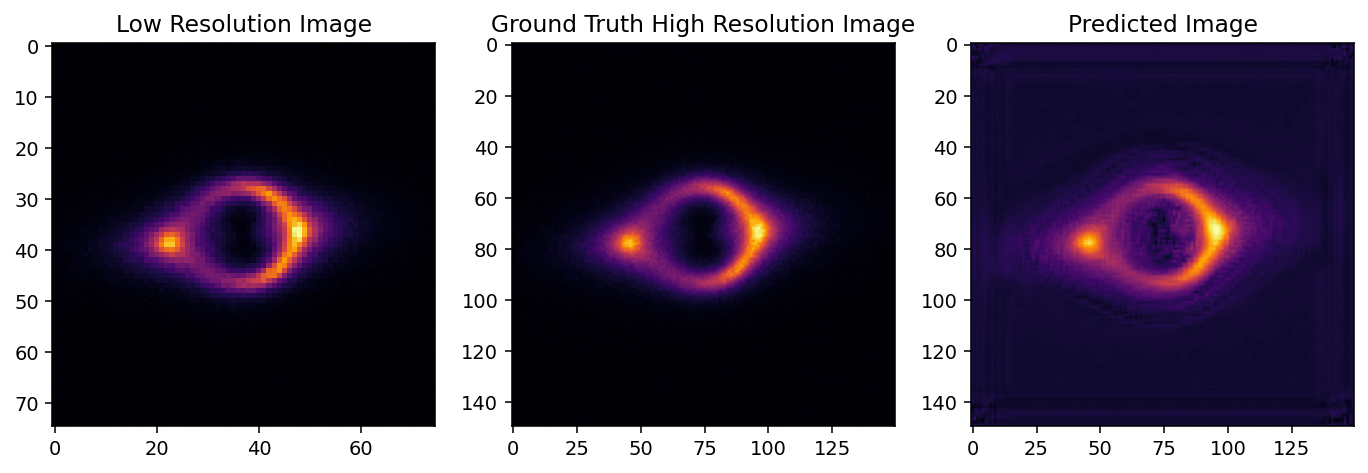

1/1 [==============================] - 0s 31ms/step


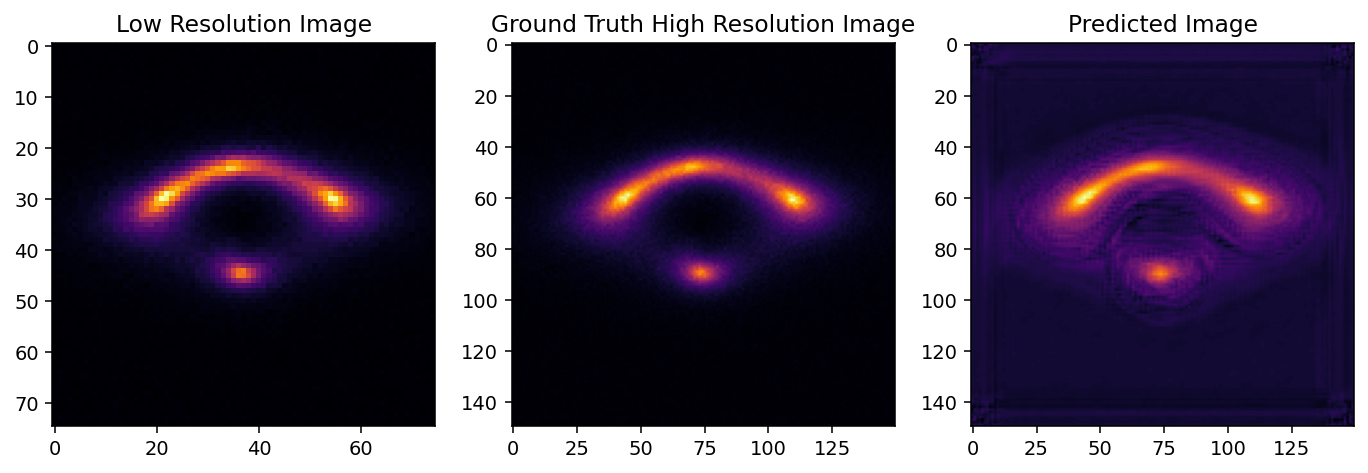

In [13]:
for i in range(5):
    view_predictions(edsr, i, f'Image {i+1}')

### ESRGAN (Enhanced Super-Resolution Generative Adversarial Networks)

In [25]:
def rrdb_block(input_layer, num_filters=256, res_scale=0.2):
    x = input_layer
    for _ in range(3):
        y = Conv2D(num_filters, kernel_size=3, strides=1, padding="same")(x)
        y = LeakyReLU(alpha=0.2)(y)
        y = Conv2D(num_filters, kernel_size=3, strides=1, padding="same")(y)
        x = Add()([x, y * res_scale])
    return x

def build_generator(num_rrdb_blocks=23):
    input_layer = Input(shape=(75, 75, 1))
    x = Conv2D(256, kernel_size=3, strides=1, padding="same")(input_layer)

    rrdb = x
    for _ in range(num_rrdb_blocks):
        rrdb = rrdb_block(rrdb)

    x = Conv2D(128, kernel_size=3, strides=1, padding="same")(rrdb)
    x = Add()([x, input_layer])

    # Upsampling using sub-pixel convolution
    x = Conv2D(128, kernel_size=3, strides=1, padding="same")(x)
    x = tf.nn.depth_to_space(x, block_size=2)
    x = LeakyReLU(alpha=0.2)(x)

    output_layer = Conv2D(1, kernel_size=3, strides=1, padding="same", activation="tanh")(x)
    return Model(inputs=input_layer, outputs=output_layer)

def build_discriminator():
    input_layer = Input(shape=(150, 150, 1))
    x = Conv2D(128, kernel_size=3, strides=1, padding="same")(input_layer)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Flatten()(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    output_layer = Dense(1, activation="sigmoid")(x)

    return Model(inputs=input_layer, outputs=output_layer)


In [26]:
import tensorflow as tf
generator = build_generator()
discriminator = build_discriminator()

# Compile the models
generator.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss="mse")
discriminator.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss="binary_crossentropy")

In [27]:
# Load the VGG19 model
vgg19 = VGG19(include_top=False, weights="imagenet")
vgg19.trainable = False

# Select the feature layer you want to use for content loss
feature_layer = vgg19.get_layer("block5_conv4").output
feature_extractor = Model(inputs=vgg19.input, outputs=feature_layer)

# Define the content loss function
mse = MeanSquaredError()

def perceptual_loss(y_true, y_pred):
    y_true = (y_true + 1) * 127.5
    y_pred = (y_pred + 1) * 127.5

    # Convert single-channel images to 3-channel images
    y_true = tf.concat([y_true, y_true, y_true], axis=-1)
    y_pred = tf.concat([y_pred, y_pred, y_pred], axis=-1)

    # Resize the images to the minimum input size expected by VGG19 (32x32)
    y_true = tf.image.resize(y_true, (32, 32))
    y_pred = tf.image.resize(y_pred, (32, 32))

    y_true_features = feature_extractor(y_true)
    y_pred_features = feature_extractor(y_pred)
    return mse(y_true_features, y_pred_features)

80134624/80134624 [==============================] - 0s 0us/step


In [28]:
# Define the combined model for training the generator
def build_combined(generator, discriminator):
    input_layer = Input(shape=(75, 75, 1))
    sr_image = generator(input_layer)
    discriminator.trainable = False
    valid = discriminator(sr_image)
    return Model(inputs=input_layer, outputs=valid)

combined = build_combined(generator, discriminator)
combined.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss="binary_crossentropy")


In [29]:
epochs = 50  
batch_size = 4

for epoch in range(epochs):
    # Train the discriminator
    idx = np.random.randint(0, train_hr.shape[0], batch_size)
    hr_batch = train_hr[idx]
    lr_batch = train_lr[idx]

    sr_batch = generator.predict(lr_batch)

    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    d_loss_real = discriminator.train_on_batch(hr_batch, real_labels)
    d_loss_fake = discriminator.train_on_batch(sr_batch, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator
    g_loss = combined.train_on_batch(lr_batch, real_labels)

    # Print the progress
    print(f"Epoch: {epoch + 1}, Discriminator loss: {d_loss}, Generator loss: {g_loss}")

1/1 [==============================] - 3s 3s/step


W0000 00:00:1711731590.905727      94 hlo_rematerialization.cc:2946] Can't reduce memory use below 5.85GiB (6281355557 bytes) by rematerialization; only reduced to 7.05GiB (7570718752 bytes), down from 7.05GiB (7570718752 bytes) originally


Epoch: 1, Discriminator loss: 0.7873146235942841, Generator loss: 5.011242866516113
1/1 [==============================] - 0s 29ms/step
Epoch: 2, Discriminator loss: 9.548976255580783, Generator loss: 1.8238205909729004
1/1 [==============================] - 0s 30ms/step
Epoch: 3, Discriminator loss: 0.3181632757768966, Generator loss: 5.741446495056152
1/1 [==============================] - 0s 29ms/step
Epoch: 4, Discriminator loss: 0.9230209290981293, Generator loss: 19.795310974121094
1/1 [==============================] - 0s 29ms/step
Epoch: 5, Discriminator loss: 0.8647073209285736, Generator loss: 7.094109535217285
1/1 [==============================] - 0s 29ms/step
Epoch: 6, Discriminator loss: 0.4532943218946457, Generator loss: 5.679348945617676
1/1 [==============================] - 0s 29ms/step
Epoch: 7, Discriminator loss: 0.5973151326179504, Generator loss: 1.864702582359314
1/1 [==============================] - 0s 28ms/step
Epoch: 8, Discriminator loss: 0.452218905091285

In [30]:
generator.save('ESRGAN.h5')

In [8]:
generator = load_model('ESRGAN.h5',compile=False)

In [32]:
mean_mse, mean_ssim, mean_psnr = evaluate_models(generator, val_lr, val_hr)
print("Mean Squared Error: ", mean_mse)
print("Structural Similarity Index: ", mean_ssim,)
print("Peak Signal-to-Noise Ratio: ",mean_psnr)

Mean Squared Error:  0.0005302784503636355
Structural Similarity Index:  0.999948555447665
Peak Signal-to-Noise Ratio:  30.793218759162485


1/1 [==============================] - 1s 1s/step


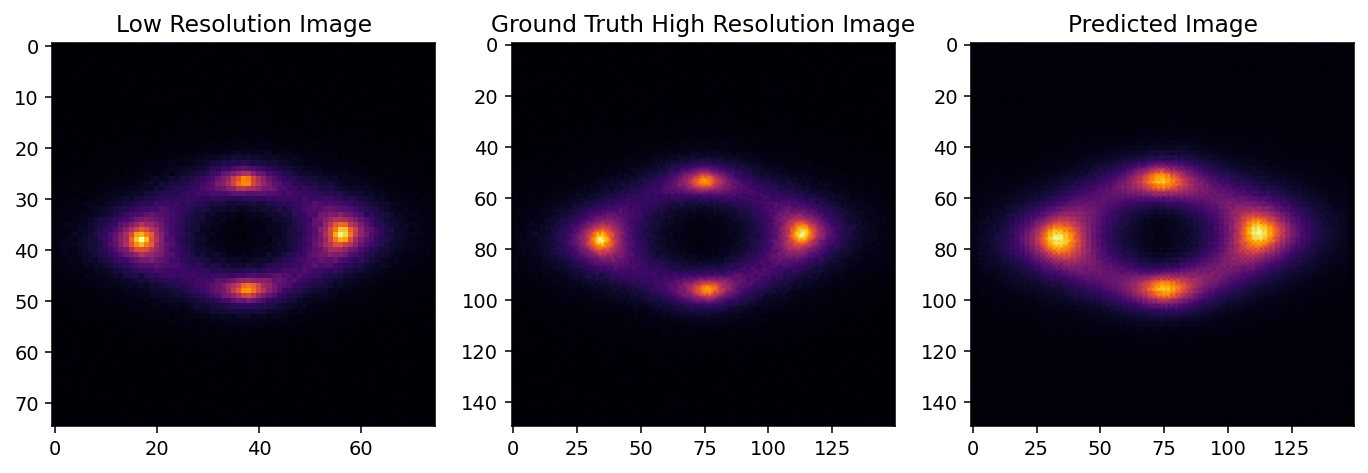

1/1 [==============================] - 0s 37ms/step


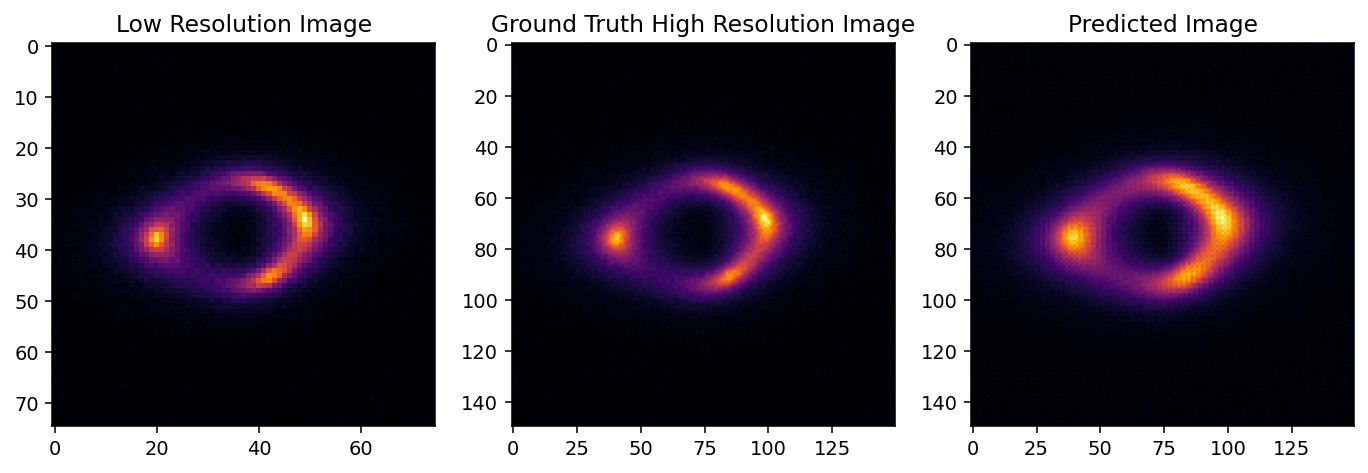

1/1 [==============================] - 0s 15ms/step


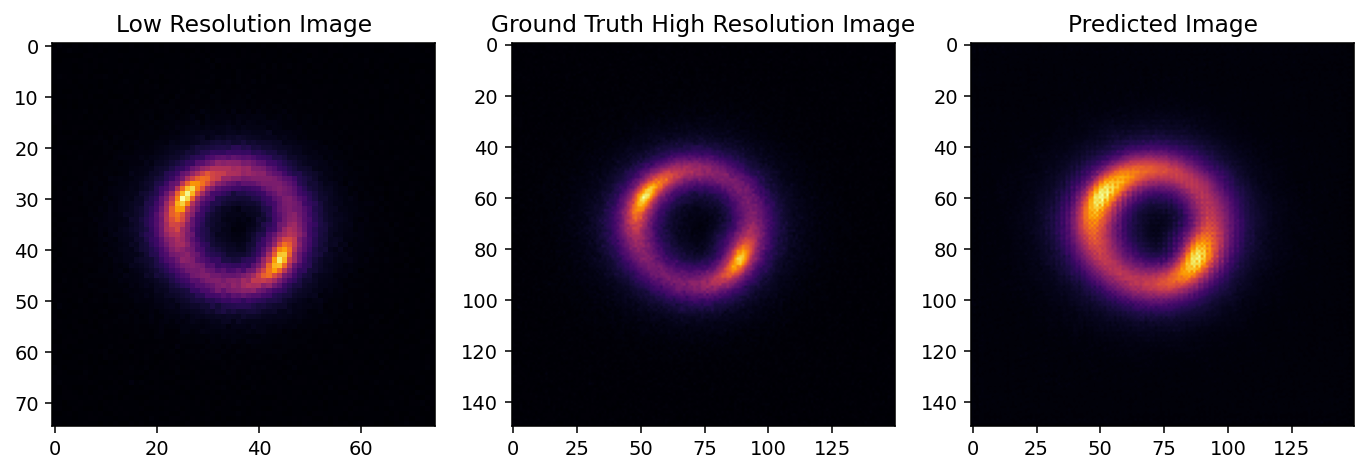

1/1 [==============================] - 0s 26ms/step


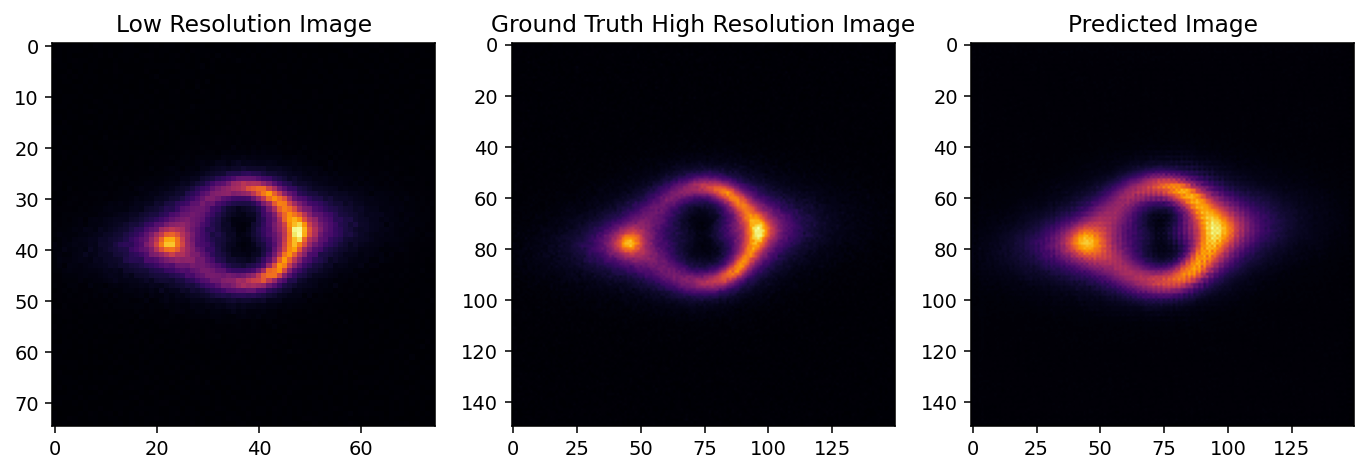

1/1 [==============================] - 0s 30ms/step


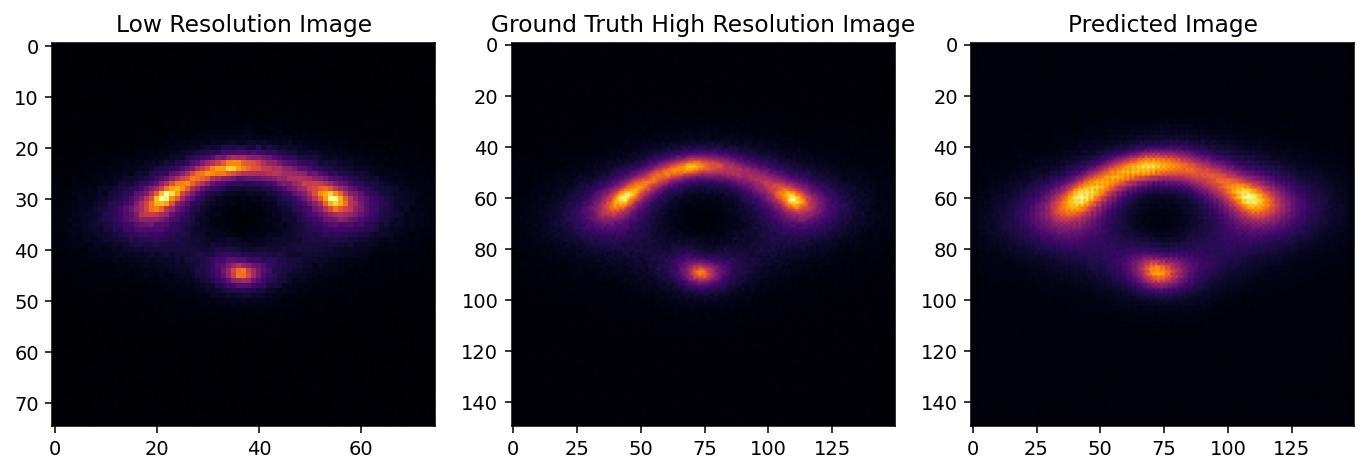

In [9]:
for i in range(5):
    view_predictions(generator, i, f'Image {i+1}')